This notebook is to analyze parameters for specufex grouping of redpy clusters.

It so far includes:

    Silhouette Score

Created 5/8/2023

Updated 5/8/2023

In [1]:
#imports
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

import pandas as pd
import h5py

In [ ]:
#pull in kmeans grouping
km_pd = pd.read_csv('/home/smocz/expand_redpy_new_files/kmeans_K_5_Volcano_Baker.csv')
km_pd.head()

In [ ]:
#confidence csv between stations
con_pd = pd.read_csv('/home/smocz/expand_redpy_new_files/confidence_K_5_Volcano_Baker.csv')
con_pd.head()

In [3]:
with h5py.File("fingerprints.h5", "r") as f: #pull in fingerprints
    fingerprints = f["fingerprints"][()]

## Silhouette Score

Testing the Silhouette Score of groups across a volcano

Silhouette sccore ranges form -1 to 1. Negative values may indicate incorrect grouping. Close to 0 means the groups are the same. Close to 1 means very well grouped

In [ ]:
# # Generating the sample data from make_blobs
# # This particular setting has one distinct cluster and 3 clusters placed close
# # together.
# X, y = make_blobs(
#     n_samples=500,
#     n_features=2,
#     centers=4,
#     cluster_std=1,
#     center_box=(-10.0, 10.0),
#     shuffle=True,
#     random_state=1,
# )  # For reproducibility

In [8]:
X = fingerprints.reshape((fingerprints.shape[0], fingerprints.shape[1]**2)) #make smaller dimension
#PCA for reduction
#testing on visually different waveforms
print(X)

[[6.91290712e-02 3.09154605e-02 1.62873654e-10 ... 1.84923926e-10
  6.89082584e-02 1.84923926e-10]
 [3.67899167e-02 2.61061952e-02 1.37250417e-10 ... 5.35557929e-02
  1.06494312e-01 9.24279482e-02]
 [8.88670631e-02 5.62022584e-02 2.09391427e-10 ... 3.10653121e-02
  1.55231256e-10 1.55231256e-10]
 ...
 [4.75979948e-02 4.75979393e-02 1.77316348e-10 ... 3.03500323e-02
  1.60210812e-10 3.03994971e-02]
 [7.84099399e-02 3.50659912e-02 1.84740127e-10 ... 2.07403546e-10
  5.04796710e-02 2.07403546e-10]
 [1.26459175e-18 1.26459175e-18 1.26459175e-18 ... 4.00303334e-02
  2.10894021e-10 2.10894021e-10]]


/home/smocz/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 2 The average silhouette_score is : 0.1552076793948751


/home/smocz/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 3 The average silhouette_score is : 0.13874959347769786


/home/smocz/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 4 The average silhouette_score is : 0.11717435048913843


/home/smocz/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5 The average silhouette_score is : 0.08979941816763734


/home/smocz/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 6 The average silhouette_score is : 0.09327178248219604


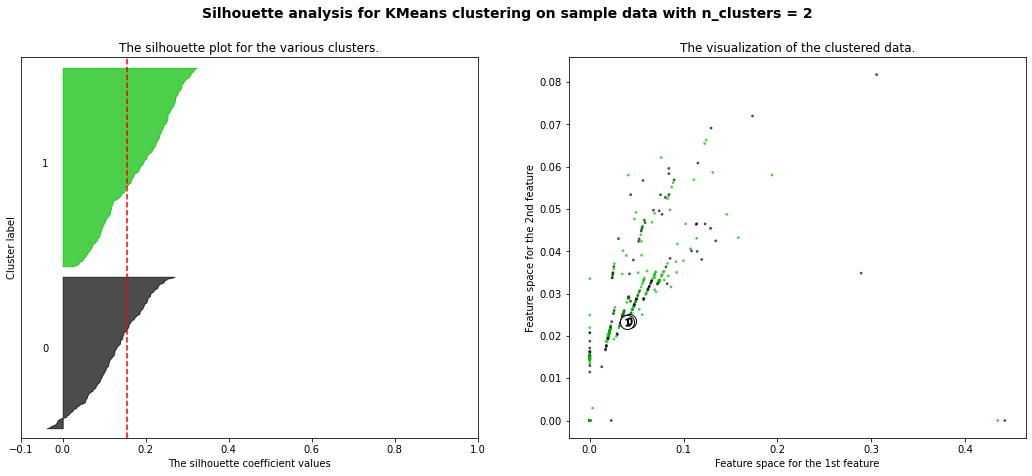

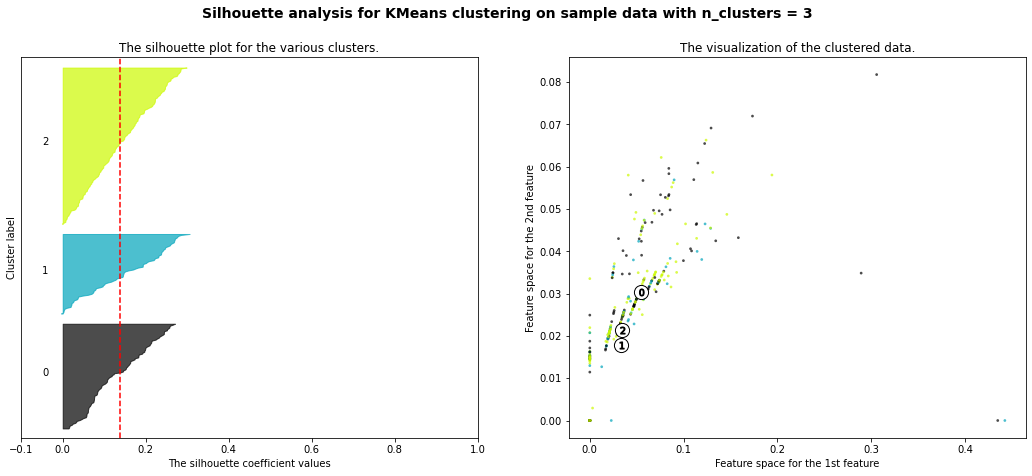

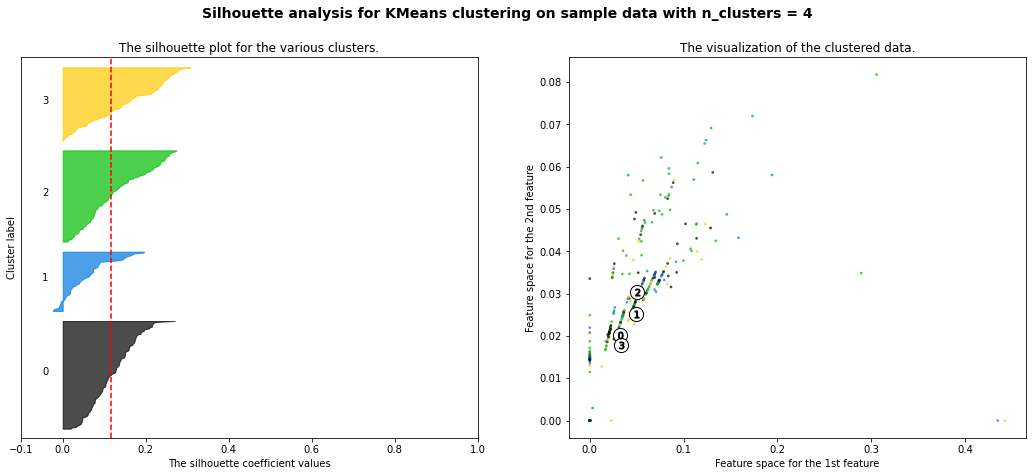

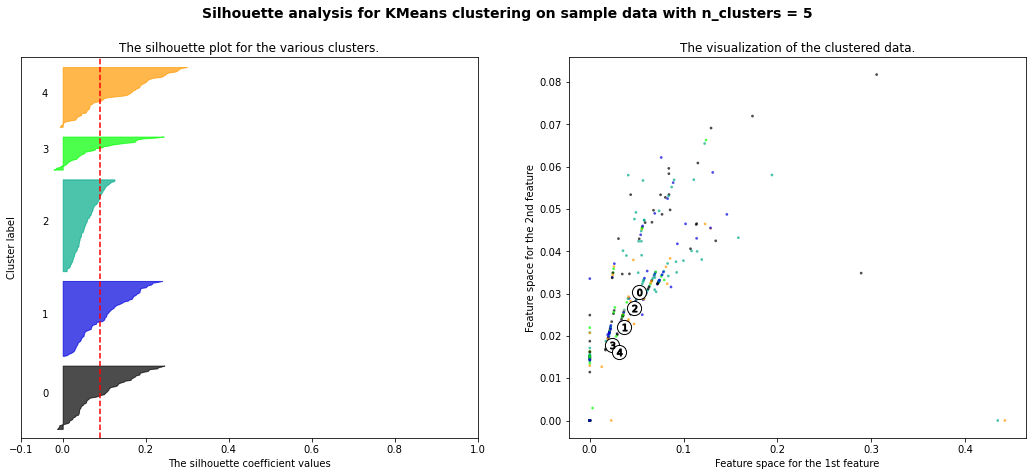

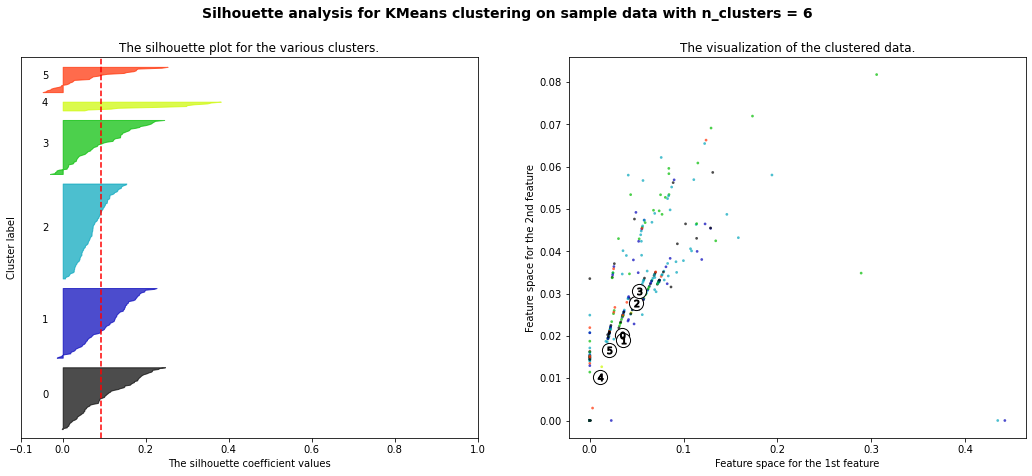

In [10]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()